Original implementation of gae-sc method
(https://github.com/ciortanmadalina/gae-sc)

In [ ]:
# !pip install scipy==1.6.0

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import h5py
import scipy as sp
from collections import Counter
import random
import pickle
import seaborn as sns
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using backend: pytorch
/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [115]:
path = "../"

category = "balanced_data"
all_data = pd.read_pickle(
    f"../output/pickle_results/{category}/{category}_combined.pkl")

clrs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#7f7f7f', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b',
    '#c49c94', '#e377c2', '#f7b6d2', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'
]
ordered_methods = [
    'graph-sc(KM)',
    'scziDesk',
    'scDeepCluster',
    'scrna',
    'cidr',
    'soup',
    'pca_kmeans',
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]

In [116]:
all_data["label"] = all_data.apply(lambda x: f"{x['nb_clust']} clusters, {x['dropout']} dropout", axis = 1)

In [117]:
xx = all_data[["dataset", "label"] ].drop_duplicates().values.T
xx.shape

(2, 12)

In [118]:
dataset_names = dict(zip(xx[0], xx[1]))

In [119]:
all_datasets = np.sort(all_data["dataset"].unique())
all_datasets

array(['data_-1c16', 'data_-1c4', 'data_-1c8', 'data_0c16', 'data_0c4',
       'data_0c8', 'data_1.5c16', 'data_1.5c4', 'data_1.5c8', 'data_1c16',
       'data_1c4', 'data_1c8'], dtype=object)

In [126]:
ranges = [np.arange(0, 6), np.arange(6,12)]
rangeid = 0

In [127]:
df = pd.read_pickle(f"../output/pickle_results/{category}/{category}_gae_features.pkl")
scDeepCluster = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scDeepCluster.pkl")
scDeepCluster["method"] = "scDeepCluster"



sczi = pd.read_pickle(f"../output/pickle_results/{category}/{category}_sczi.pkl")
sczi["method"] = "scziDesk"

desc = pd.read_pickle(f"../output/pickle_results/{category}/{category}_scGNN.pkl")
desc["method"] = "scGNN"
datasets = all_datasets[ranges[rangeid]]
datasets

array(['data_-1c16', 'data_-1c4', 'data_-1c8', 'data_0c16', 'data_0c4',
       'data_0c8'], dtype=object)

In [128]:
def get_2d(all_data, dataset):
    ours = all_data[(all_data["dataset"] == dataset) & (all_data["run"] == 0)]
    ari = round(ours["ARI"].values[0], 2)
    emb = ours["features"].values[0]
    n_clust = np.unique(ours["pred"].values[0]).shape[0]

    X_embedded = TSNE(n_components=2, random_state = 0).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])

    X_embedded["clusters"] = ours["pred"].values[0]
    X_embedded["clusters"] = X_embedded["clusters"].apply(lambda x : f"c {x}")
    return X_embedded, ari, n_clust

In [129]:
embedding_map = {}

In [130]:
all_data.columns

Index(['dataset', 'ARI', 'NMI', 'Silhouette', 'Calinski', 'run', 'time',
       'pred', 'method', 'features', 'dropout', 'nb_clust', 'order', 'label'],
      dtype='object')

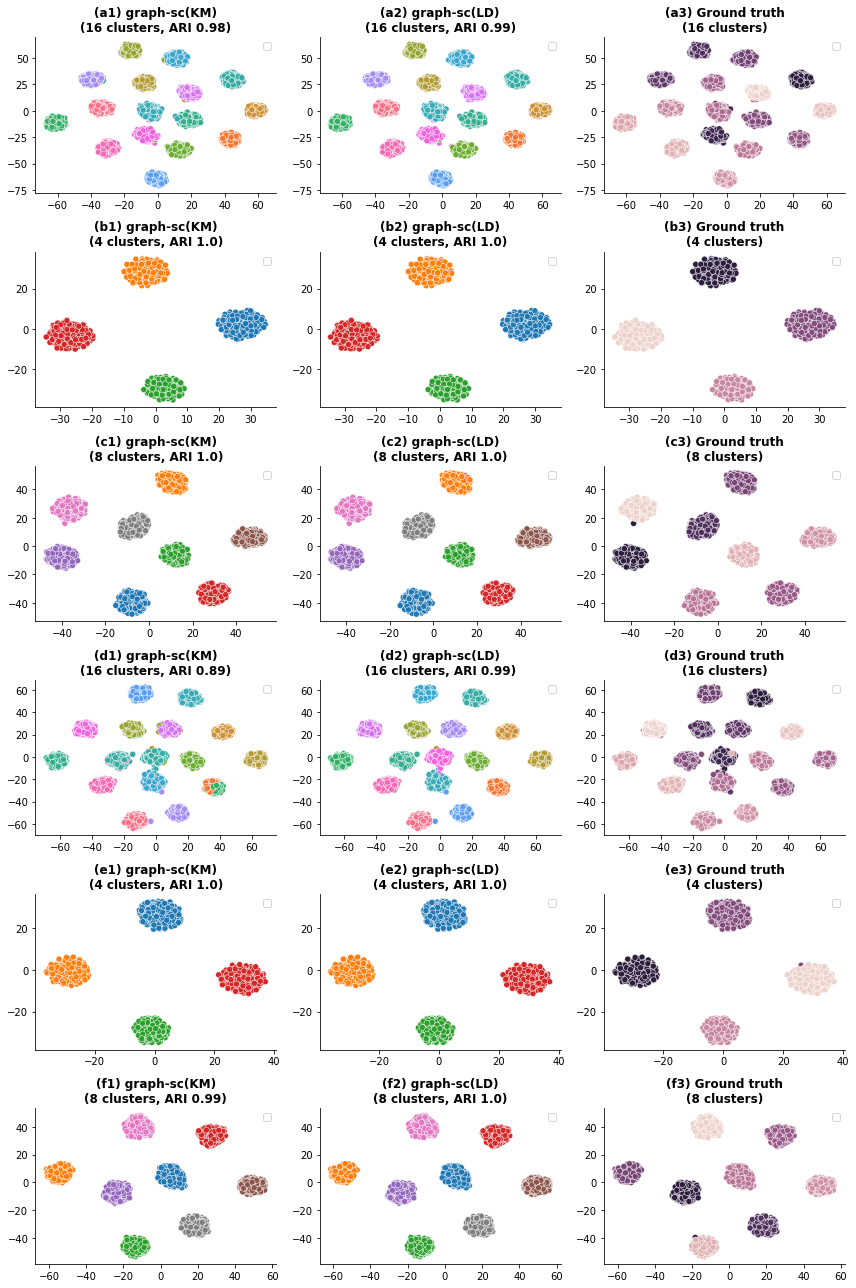

In [131]:
n = len(datasets)
titles = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
plt.figure(figsize = (12, 3*n))
n_cols = 3
nb_rows = n
for i in range(n):
    dataset = datasets[i]
    # OURS
    data_mat = h5py.File(f"{path}R/simulated_data/{category}/{dataset}.h5",
                         "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    if 'cell_names' in data_mat.keys():
        cell_names = data_mat['cell_names'][()]
    else:
        cell_names = Y

    ours = df[(df["dataset"] == dataset)]

    emb = ours["features"].values[0]

    X_embedded = TSNE(n_components=2, random_state = 0).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
    X_embedded[dataset] = cell_names

    X_embedded["K Means"] = ours["kmeans_pred"].values[0]
    X_embedded["Leiden"] = ours["leiden_pred"].values[0]

    X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
    X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
#     X_embedded = embedding_map[dataset]
    # plot
    
    
    ax = plt.subplot(nb_rows, n_cols,  i*n_cols+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}1) graph-sc(KM)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+2)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax,
              )
    ari = round(ours["leiden_ari"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"({titles[i]}2) graph-sc(LD)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    plt.legend([])
    plt.xlabel("")
    plt.ylabel("")
#     if i == 0:
#         plt.suptitle("Panel b")
    sns.despine()

    ax = plt.subplot(nb_rows, n_cols,  i*n_cols+3)
    sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue=dataset,
               ax = ax
              )
    plt.legend([])
#     plt.legend(bbox_to_anchor=(1.05,1.2), loc=2, borderaxespad=0., ncol = 1, 
#                title = dataset_names.get(dataset, dataset) )
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}3) Ground truth\n({n_clust} clusters)", fontweight = "bold")
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()
    
plt.tight_layout()

plt.savefig(f"../diagrams/{category}_ground_truth_{rangeid}.pdf", bbox_inches='tight')

In [ ]:
n = len(datasets)
titles = ["a", "b", "c", "d", "e", "f"]
plt.figure(figsize = (15, 3*n))
n_cols = 5
nb_rows = n
for i in range(n):
    dataset = datasets[i]
    # scDeepCluster
    X_embedded, ari, n_clust = get_2d(scDeepCluster, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+1)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}1) scDeepCluster\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    xmin, xmax = ax.get_xlim()
    plt.text(xmin - (xmax - xmin )/2, 0,dataset_names.get(dataset, dataset), fontweight = "bold")
    sns.despine()
    
    # sczi
    X_embedded, ari, n_clust = get_2d(sczi, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+2)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}2) scziDesk\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    # desc
    X_embedded, ari, n_clust = get_2d(desc, dataset)
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+3)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="clusters",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    plt.title(f"({titles[i]}3) scGNN\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    
    # OURS
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    if 'cell_names' in data_mat.keys():
        cell_names = data_mat['cell_names'][()]
    else:
        cell_names = Y

    ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

    emb = ours["features"].values[0]

    X_embedded = TSNE(n_components=2).fit_transform(emb)

    X_embedded = pd.DataFrame(data= X_embedded, columns = ["x", "y"])
    X_embedded[dataset] = cell_names

    X_embedded["K Means"] = ours["kmeans_pred"].values[0]
    X_embedded["Leiden"] = ours["leiden_pred"].values[0]

    X_embedded["K Means"] = X_embedded["K Means"].apply(lambda x : f"c {x}")
    X_embedded["Leiden"] = X_embedded["Leiden"].apply(lambda x : f"c {x}")
    embedding_map[dataset] = X_embedded
    # plot
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+4)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="K Means",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["kmeans_ari"].values[0], 2)
    n_clust = X_embedded["K Means"].unique().shape[0]
    plt.title(f"({titles[i]}4) graph-sc(KM)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    xmin, xmax = ax.get_xlim()
#     plt.text(xmax, 0,dataset_names.get(dataset, dataset).replace('\n', " ")  , fontweight = "bold")
    sns.despine()
    
    
    
    # plot
    ax = plt.subplot(nb_rows, n_cols, i*n_cols+5)
    p = sns.scatterplot(data=X_embedded,
               x='x',
               y='y',
               hue="Leiden",
               ax = ax
              )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])
    ari = round(ours["leiden_ari"].values[0], 2)
    n_clust = X_embedded["Leiden"].unique().shape[0]
    plt.title(f"({titles[i]}5) graph-sc(LD)\n({n_clust} clusters, ARI {ari})", fontweight = "bold")
    sns.despine()
    
    

    
plt.tight_layout()

plt.savefig(f"../diagrams/{category}_TSNE_clusters_{rangeid}.pdf", bbox_inches='tight')

In [ ]:
dataset = 'Quake_10x_Bladder'#'Quake_10x_Limb_Muscle'

In [ ]:
data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])

cell_names = data_mat['cell_names'][()]

ours = df[(all_data["dataset"] == dataset) & (df["run"] == 0)]

pred = ours["kmeans_pred"].values[0]
idx = np.where(pred!= Y)[0]
print(len(idx), X.shape)
print(len(Y), adjusted_rand_score(Y, pred))

In [ ]:
cell_names = data_mat['cell_names'][()]

In [ ]:
Y, cell_names

In [ ]:
Xb = (X>0).astype(int)

In [ ]:
idx0 = np.where(pred == 0)[0]
idx1 = np.where(pred == 1)[0]
idx2 = np.where(pred == 2)[0]
idx3 = np.where(pred == 3)[0]
pred[idx1] = 0
pred[idx0] = 1
idx = np.where(pred!= Y)[0]
print(len(idx))
pred[idx][:20], Y[idx][:20]

In [ ]:
pred[idx2] = 3
pred[idx3] = 2
idx = np.where(pred!= Y)[0]
print(len(idx))

In [ ]:
len(idx), pred[idx][:20], Y[idx][:20]

In [ ]:
plt.hist(X.mean( axis = 1), bins = 30, log= True)

plt.hist(X[idx].mean( axis = 1), bins = 30, log= True)

In [ ]:
plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.title("(a) Average cell expression value \nin Q Bladder", fontweight = "bold")
plt.hist(X.mean( axis = 1), bins = 30);
plt.xlabel("Average cell expression value")
plt.ylabel("Frequency")
plt.subplot(122)
plt.title("(b) Average expression value in cells \npredicted in the wrong cluster", fontweight = "bold")
plt.xlabel("Average cell expression value")
plt.ylabel("Frequency")
plt.hist(X[idx] .mean( axis = 1), bins = 30);
sns.despine()
plt.savefig(f"../diagrams/{category}_wrong_predictions.pdf", bbox_inches='tight')

# Data augmentation analysis

In [ ]:
layers = pd.read_pickle(f"../output/pickle_results/real_data/real_data_layers_new.pkl")
dropout = layers[layers["layers"] == "[200, 40, 60]"]

In [ ]:
plt.figure(figsize = (13,6))
ax = plt.subplot(241)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_ari', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(a) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-3, 0.6, "Ratio of\nmasked\ngenes\n(dropout\nlayer)", 
         fontweight = "bold", fontsize = 12)
# plt.ylabel("")


ax = plt.subplot(242)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_nmi', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(b) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))



ax = plt.subplot(243)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = dropout.groupby(['dropout'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("NN dropout ratio" )
sns.despine()
plt.title("(c) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(244)
sns.boxplot(data = dropout, x = "dropout", y='kmeans_cal', ax = ax, color="royalblue")
means = dropout.groupby(['dropout'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 18000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("NN dropout ratio")
sns.despine()
plt.title("(d) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))
#####
noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")
ax = plt.subplot(245)
sns.boxplot(data = noise, x = "noise", y='kmeans_ari', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_ari'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("std added noise")
sns.despine()
plt.title("(e) ARI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.text(-3, 0.8, "Noise\nadded\nto input\ndata", 
         fontweight = "bold", fontsize = 12)
# plt.ylabel("")


ax = plt.subplot(246)
sns.boxplot(data = noise, x = "noise", y='kmeans_nmi', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_nmi'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 1.02, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("nmi")
plt.xlabel("std added noise")
sns.despine()
plt.title("(f) NMI scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))

ax = plt.subplot(247)
sns.boxplot(data = noise, x = "noise", y='kmeans_sil', ax = ax, color="royalblue")
plt.ylabel("Silhouette")
means = noise.groupby(['noise'])['kmeans_sil'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 0.87, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.xlabel("std added noise")
sns.despine()
plt.title("(g) Silhouette scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))


ax = plt.subplot(248)
sns.boxplot(data = noise, x = "noise", y='kmeans_cal', ax = ax, color="royalblue")
means = noise.groupby(['noise'])['kmeans_cal'].mean().values
mean_labels = [str(int(s)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], 27000, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("cal")
plt.xlabel("std added noise")
sns.despine()
plt.title("(h) Calinski scores", fontweight = "bold")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 2000))

plt.tight_layout()
plt.savefig(f"../diagrams/{category}_data_augmentation.pdf", bbox_inches='tight')

# ARI correlation

In [ ]:
df = all_data[['dataset', "method", 'ARI', 'NMI','Silhouette', 'Calinski']]
df.head()

df['Silhouette'] = df['Silhouette'].astype(float)
df['Calinski'] = df['Calinski'].astype(float)

corr_ari = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr_ari is None:
        corr_ari = desc_m
    else:
        corr_ari = pd.concat([corr_ari, desc_m], axis =1)

corr_ari = corr_ari.round(2)

idx = corr_ari.index.values
idx = [f"corr(ARI-{x})" for x in idx]

corr_ari = corr_ari.reset_index()

corr_ari["index"] = idx
corr_ari

corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-ARI)"]
corr_ari = corr_ari[corr_ari["index"]!= "corr(ARI-Calinski)"]


corr_sil = None

for method in df.method.unique():
    desc_m = df[df["method"] == method]
    desc_m = desc_m.corr()[["Silhouette"]].rename(columns={"Silhouette": method})
    if corr_sil is None:
        corr_sil = desc_m
    else:
        corr_sil = pd.concat([corr_sil, desc_m], axis =1)

corr_sil = corr_sil.round(2)

idx = corr_sil.index.values
idx = [f"corr(Silhouette-{x})" for x in idx]

corr_sil = corr_sil.reset_index()

corr_sil["index"] = idx
corr_sil

corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Silhouette)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-ARI)"]
corr_sil = corr_sil[corr_sil["index"]!= "corr(Silhouette-Calinski)"]


corr_ari = pd.concat([corr_ari, corr_sil])

corr_ari  = corr_ari.set_index("index", drop = True)

In [ ]:
# plt.figure(figsize = (12, 2))
# ax = plt.gca()
# sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
# plt.ylabel("");
# plt.savefig(f"../diagrams/ari_corr_arielation.pdf", bbox_inches='tight')

# Correlation score vs sparsity, etc

In [ ]:
desc = pd.read_excel("../output/pickle_results/real_data/description.xlsx")
desc = desc[['dataset', 'nb_clusters', 'sparsity', 'max_value',
       'non_zero_mean', 'non_zero_median', 'non_zero_skew', 'non_zero_kurosis']]
desc.head()


df = all_data[['dataset', "method", "ARI"]]

desc = pd.merge(desc, df, on = "dataset", how = "right")

corr = None

for method in desc.method.unique():
    desc_m = desc[desc["method"] == method]
    desc_m = desc_m.corr()[["ARI"]].rename(columns={"ARI": method})
    if corr is None:
        corr = desc_m
    else:
        corr = pd.concat([corr, desc_m], axis =1)

corr = corr.round(2)

corr = corr[corr.index != "ARI"].reset_index()

labels = {
    'nb_clusters': "Nb of clusters",
    'sparsity': "Sparsity (ratio of 0 values)",
    'max_value': "Max value",
    'non_zero_mean': "Mean value",
    'non_zero_median': "Median value",
    'non_zero_skew': "Skew",
    'non_zero_kurosis': "Kurtosis"
}
corr["index"] = corr["index"].apply(lambda x: labels[x])
corr = corr.set_index("index", drop = True)
corr = corr[ordered_methods]
corr

In [ ]:
plt.figure(figsize = (12, 9))
ax = plt.subplot(311)
plt.title("(a) Correlation of clustering scores", fontweight = "bold")
sns.heatmap(corr_ari[ordered_methods], annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");

ax = plt.subplot(212)
plt.title("(b) Correlation between the ARI score and dataset properties", fontweight = "bold")
sns.heatmap(corr, annot = True, cmap = "coolwarm", ax = ax)
plt.ylabel("");
plt.tight_layout()
plt.savefig(f"../diagrams/meta_correlation.pdf", bbox_inches='tight')

In [ ]:
sel_methods = ['graph-sc(KM)', 'graph-sc(LD)', 'scziDesk', 'scDeepCluster', 'desc', 'scanpy-seurat']

In [ ]:
sel_desc = desc[desc.method.isin(sel_methods)]

In [ ]:
sel_desc = sel_desc.rename(columns = {"nb_clusters": "Nb. of clusters" })

In [ ]:
g = sns.FacetGrid(sel_desc, col="method",  col_wrap=3, height=3, 
                  ylim=(0, 1)
                 )
g.map(sns.regplot, "Nb. of clusters", "ARI")
plt.savefig(f"../diagrams/perf_by_nb_of_clusters.pdf", bbox_inches='tight')

# Scalability

In [ ]:
# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_cells.pkl")

# sc = sc[["nb_cells", "t_k", "t_l", "t_training"]]
# sc["nb_cells"] =sc["nb_cells"].astype(int)
# sc = sc.rename(columns = {"nb_cells": "Nb cells", 
#                           "t_k": "2. Complete gae +KMeans", 
#                           "t_l": "3. Complete gae +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb cells",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb cells", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# sc = pd.read_pickle(f"../output/pickle_results/balanced_data/balanced_data_scalability_genes.pkl")

# sc = sc[["nb_genes", "t_k", "t_l", "t_training"]]
# sc["nb_genes"] =sc["nb_genes"].astype(int)
# sc = sc.rename(columns = {"nb_genes": "Nb genes", 
#                           "t_k": "2. Complete gae +KMeans", 
#                           "t_l": "3. Complete gae +Leiden", 
#                           "t_training": "1. Representation learning only"})

# sc = pd.melt(sc, id_vars="Nb genes",).rename(columns={"variable" : "Method"}).sort_values(by = "Method")

# sns.barplot(x = "Nb genes", y= "value",hue = "Method", data = sc)
# plt.ylabel("time (seconds)")
# sns.despine()

# Nb input epochs

In [ ]:
# nb_epochs = pd.read_pickle(f"../output/pickle_results/real_data/real_data_nb_epochs.pkl")
# nb_epochs["nb_epochs"] = nb_epochs["nb_epochs"].astype("int")

In [ ]:
# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_ari', ax = ax)
# plt.ylabel("ARI")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = nb_epochs, x = "nb_epochs", y='kmeans_sil', ax = ax)
# plt.ylabel("Silhouette")
# plt.xlabel("Number of training epochs")
# sns.despine()
# plt.title("(b) Silhouette")
# plt.savefig(f"../diagrams/{category}_nb_epochs.pdf", bbox_inches='tight')

# Noise analysis

In [ ]:
# noise = pd.read_pickle(f"../output/pickle_results/real_data/real_data_noise.pkl")

# plt.figure(figsize = (10, 3))
# ax = plt.subplot(121)
# sns.boxplot(data = noise, x = "noise", y='kmeans_ari_0', ax = ax)
# means = noise.groupby(['noise'])['kmeans_ari_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.ylabel("ARI")
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(a) ARI")
# ax = plt.subplot(122)
# sns.boxplot(data = noise, x = "noise", y='kmeans_nmi_0', ax = ax)
# plt.ylabel("NMI")
# means = noise.groupby(['noise'])['kmeans_nmi_0'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick], 1.01, mean_labels[tick], 
#             horizontalalignment='center', #size='x-small', color='w', weight='semibold'
#            )
# plt.xlabel("Noise std")
# sns.despine()
# plt.title("(b) NMI")


In [ ]:
import scanpy.api as sc

In [ ]:
??sc.pp.highly_variable_genes

# Worm dataset analysis

In [ ]:
dataset_names_worm = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES Cell',
    'mouse_ES_cell_select_2100': 'Mouse ES Cell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron Cell (2100)',
    'worm_neuron_cell': 'Worm Neuron Cell',
    'mouse_bladder_cell': 'Mouse Bladder Cell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder  Cell (2100)',
    'Quake_Smart-seq2_Trachea': 'QS Trachea',
    'Quake_Smart-seq2_Diaphragm': 'QS Diaphragm',
    'Quake_10x_Spleen': 'Q Spleen',
    'Quake_10x_Bladder': 'Q Bladder',
    'Quake_Smart-seq2_Lung': 'QS Lung',
    'Quake_10x_Limb_Muscle': 'Q Limb Muscle',
    'Quake_Smart-seq2_Limb_Muscle': 'QS Limb Muscle',
    'Adam': "Adam",
    'Muraro': "Muraro",
    'Romanov': "Romanov",
    'Young': "Young",
}
worm_order =dict(zip(list(dataset_names_worm.keys()), np.arange(len(dataset_names_worm))))
df = pd.read_pickle(
    f"{path}output/pickle_results/real_data/real_data_dataset_tuning.pkl")
df = df.groupby(["dataset",
                 "nb_genes"])[["kmeans_ari_0", "sparsity"
                               ]].mean().unstack("nb_genes").reset_index()
df.columns = ["dataset", "500", "1500", "5000", "sparsity", "s1", "s2"]
df["order"] = df["dataset"].apply(
    lambda x: worm_order.get(x, x))
df = df.sort_values(by = "order")
df["dataset"] = df["dataset"].apply(
    lambda x: dataset_names_worm.get(x, x))

df = df.drop(["s1", "s2", "order"], axis=1).set_index("dataset").round(3)

df

In [ ]:
nb_genes = pd.read_pickle(f"../output/pickle_results/real_data/real_data_worm.pkl")
nb_genes["nb_genes"] = nb_genes["nb_genes"].astype(int)

In [ ]:
plt.figure(figsize = (10, 7))
ax = plt.subplot(221)
g = sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_ari_0', ax = ax)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_ari_0"].max() + 0.01
means = nb_genes.groupby(['nb_genes'])['kmeans_ari_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("ARI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(a) ARI")
ax = plt.subplot(223)
ylim = nb_genes.groupby("nb_genes").max()["kmeans_nmi_0"].max()+ 0.01
sns.boxplot(data = nb_genes, x = "nb_genes", y='kmeans_nmi_0', ax = ax)
means = nb_genes.groupby(['nb_genes'])['kmeans_nmi_0'].mean().values
mean_labels = [str(np.round(s, 2)) for s in means]
pos = range(len(means))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], ylim, mean_labels[tick], 
            horizontalalignment='center', #size='x-small', color='w', weight='semibold'
           )
plt.ylabel("NMI")
plt.xlabel("Nb of selected genes in Worm Neuron Cell dataset")
sns.despine()
plt.title("(b) NMI")
ax = plt.subplot(1,2,2)
sns.heatmap(df, annot = True, cmap = "coolwarm",fmt='.3g', ax = ax)
plt.ylabel("");
plt.title("(c)")
plt.tight_layout()
plt.savefig(f"../diagrams/{category}_worm.pdf", bbox_inches='tight')